In [13]:
from collections import Counter
import itertools
from itertools import zip_longest
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import nltk
from nltk.corpus import stopwords
import numpy as np
from numpy.linalg import norm
import pandas as pd
import seaborn as sns
from scipy import sparse
from scipy.sparse import linalg 
from scipy.sparse import dok_matrix
from scipy.sparse import csr_array
from scipy.sparse import find
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity


df = pd.read_csv('../input/abcnews-date-text.csv')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
df['tokenized'] = df.headline_text.str.split(' ')

df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]
df=df.sample(frac=0.005)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#explode and sanitize

ex = df.explode('tokenized')

ex = ex.loc[ex.tokenized.str.len() > 2]

ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

In [15]:
#ceate dictionary of words

dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

words = dictionary.tolist()

dictionary = pd.Series(words, name='words')

dictionary = dictionary.to_frame()

dictionary_lookup = dictionary.to_dict()['words']

dictionary['encode'] = dictionary.index + 1

dictionary = dictionary.set_index('words')

dictionary.encode = dictionary.encode
dictionary = dictionary.to_dict()['encode']


In [16]:
#reduced grouping to series and aggregated to tuple
#improved from 30s to 20s

encode = ex.tokenized.map(dictionary.get).to_frame()
encode.index.astype('int')
encode.tokenized.astype('int')
docs = encode.tokenized.groupby(level=0).agg(tuple)


In [17]:

#zero pad x dimention by longest sentence
encoded_docs = list(zip(*zip_longest(*docs.to_list(), fillvalue=0)))

#convert to sparse matrix
encoded_docs = csr_array(encoded_docs, dtype=int)

#convert to index for each word
row_column_code = find(encoded_docs)

#presort by words
word_sorted_index = row_column_code[2].argsort()

doc_word = np.array([row_column_code[0][word_sorted_index], row_column_code[2][word_sorted_index]])

#presort by docs and words
doc_word_sorted_index = doc_word[0].argsort()

doc_word = pd.DataFrame(np.array([doc_word[0][doc_word_sorted_index], doc_word[1][doc_word_sorted_index]]).T, columns=['doc','word'])

doc_word.word = doc_word.word - 1

#convert to index of word counts per document
doc_word_count  = doc_word.groupby(['doc','word']).size().to_frame('count').reset_index().to_numpy().T

#convert to sparse matrix
sparse_doc_word_matrix = csr_array((doc_word_count[2],(doc_word_count[0],doc_word_count[1])), shape=(np.size(encoded_docs, 0),len(dictionary)), dtype=float).T


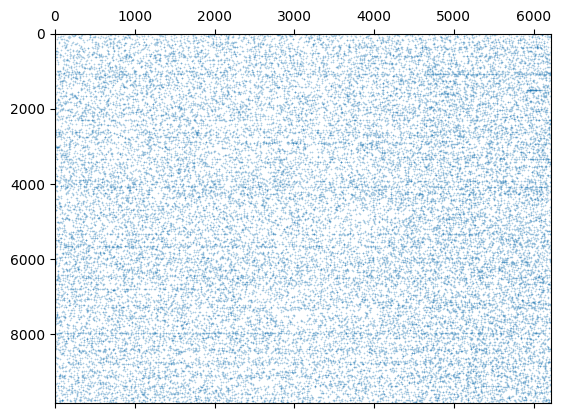

In [18]:
#visualize sparse matrix
# 1.06 TiB for an array with shape (1242915, 116795)

#fig = figure(figsize=[15, 15])
#sparse_doc_word_matrix_visualization = fig.add_subplot(1,1,1)
#sparse_doc_word_matrix_visualization.spy(sparse_doc_word_matrix, markersize=0.0016, aspect = 'auto')


fig = figure()
sparse_doc_word_matrix_visualization = fig.add_subplot(1,1,1)

sparse_doc_word_matrix_visualization.spy(sparse_doc_word_matrix, markersize=0.1, aspect = 'auto')



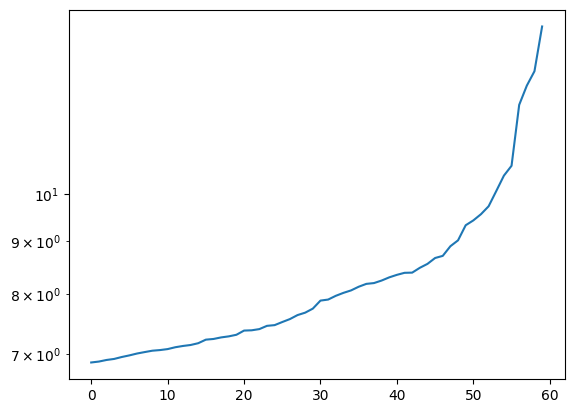

In [23]:
#U S VT
#U & VT representations of isometric transformations of the space
#S/Σ scaling of each xi by factor σi

terms, concepts, documents = svds(sparse_doc_word_matrix, k=60)

fig = figure()
singular_values = fig.add_subplot(1,1,1)

#Singular values at log scale
singular_values.set_yscale('log')
singular_values.plot(concepts)



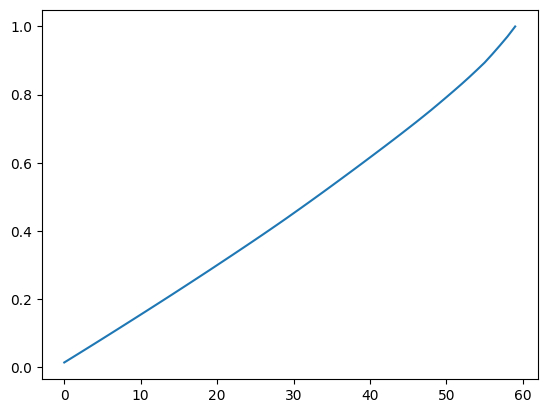

In [24]:
fig = figure()
cum_singular_values = fig.add_subplot(1,1,1)

#Cumulative singular values
cum_singular_values.plot(np.cumsum(concepts) / sum(concepts))

In [28]:

k=2
#words as k-vectors
#terms[allwords x 2-vectors] dot diagonal matrix of first two sigma values
terms_s = terms[:, :k] @ np.diag(concepts[:k])

word_vectors_2d = pd.DataFrame(terms_s, index=words, columns=['x','y'])

word_vectors_2d


,x,y
pormpuraaw,-0.006436,-0.006673
mayor,0.044802,0.015527
carter,0.018640,-0.015616
recruiter,-0.008266,0.032709
sport,0.044841,-0.049183
...,...,...
sets,0.003834,0.018873
berlusconi,-0.000612,0.000772
rental,-0.004721,0.027173
chasing,0.005926,-0.016601


In [31]:
word_vectors_2d['magnitude'] = word_vectors_2d['x'].pow(2)+word_vectors_2d['y'].pow(2)

word_vectors_2d['angle'] = np.arctan(word_vectors_2d['y']/word_vectors_2d['x'])

word_vectors_2d.sort_values(by=['angle'])

,x,y,magnitude,angle
nuerodiversity,-0.000020,0.038871,0.001511,-1.570287
fund,0.000025,-0.032831,0.001078,-1.570043
holds,-0.000096,0.087785,0.007706,-1.569708
cowan,-0.000004,0.003291,0.000011,-1.569487
wells,-0.000004,0.002120,0.000004,-1.569067
...,...,...,...,...
normanton,0.000030,0.014039,0.000197,1.568625
$8.5m,0.000030,0.014039,0.000197,1.568625
arena,0.000030,0.014039,0.000197,1.568625
italian,0.000077,0.044829,0.002010,1.569077
